# Exploring `build_renewable_profiles.py` outputs

This jupyter notebook analyse the `build_renewable_profiles.py` **outputs**. Outputs are for instance the timeseries of wind or solar power plants.

The `pypsa-africa/Snakefile` explicitly list in the **rule** what goes into the function `build_renewable_profiles.py` and what goes out (`build_renewable_profiles_{technology}.nc`). So to create the renewable timeseries, we need to provide:
- the base_network
- natura raster, areas where renewables are excluded i.e. areas under protection (generated in `build_natura_raster`)
- copernicus, global land cover data (classifies land data)
- gebco, bathemetry data (deepness of sea)
- cutout, environmental data timeseries such as wind speed and irradiation
```
rule build_renewable_profiles:
    input:
        base_network="networks/base.nc",
        natura="resources/natura.tiff",
        copernicus="data/raw/copernicus/PROBAV_LC100_global_v3.0.1_2019-nrt_Discrete-Classification-map_EPSG-4326.tif",
        gebco="data/raw/gebco/GEBCO_2021_TID.nc",
        country_shapes='resources/country_shapes.geojson',
        offshore_shapes='resources/offshore_shapes.geojson',
        regions=lambda w: ("resources/regions_onshore.geojson"
                                   if w.technology in ('onwind', 'solar', "hydro")
                                   else "resources/regions_offshore.geojson"),
        cutout=lambda w: "cutouts/" + config["renewable"][w.technology]['cutout'] + ".nc",
    output: profile="resources/profile_{technology}.nc",
    log: "logs/build_renewable_profile_{technology}.log"
    benchmark: "benchmarks/build_renewable_profiles_{technology}"
    threads: ATLITE_NPROCESSES
    resources: mem=ATLITE_NPROCESSES * 5000
    script: "scripts/build_renewable_profiles.py"
```


Before analysing the outputs of add_electricity.py check that:
- `pypsa-africa` environment (/kernel) in jupyter notebook  is active and updated
- root folder where pypsa-africa is installed is named "pypsa-africa"
- or rename the below `_sets_path_to_root("<folder_name>")` accordingly

In [1]:
import os
import sys
sys.path.append('../')  # to import helpers
from scripts._helpers import _sets_path_to_root
_sets_path_to_root("pypsa-africa")

This is the repository path:  /home/max/OneDrive/PHD-Flexibility/07_pypsa-africa/0github/pypsa-africa/pypsa-africa-fork/pypsa-africa
Had to go 1 folder(s) up.


A jupyter notebook requires the user to import all they need. So we need to import all the required dependencies from the `pypsa-africa` environment:

In [2]:
import atlite
import cartopy.crs as ccrs
import xarray as xr
import geopandas as gpd
import holoviews as hv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
import pypsa
import shutil
from rasterio.plot import show
from atlite.gis import shape_availability, ExclusionContainer


plt.rcParams['figure.figsize'] = [7, 7]
%matplotlib inline

## Generate profiles (if not already available)

If you don't have the renewable profiles such as:
- `resources/profile_solar.nc`
- `resources/profile_onwind.nc`
- `resources/profile_offwind-ac.nc`

you could try to generate them from the terminal. In this case set the path so that you are located at ~/pypsa-africa. Once you are there, use the command:

```
snakemake -j 1 resources/profile_{technology}.nc
```

replace {technology} for the timeseries of interest.

## Let's open the profiles
The `build_renewable_profiles` for each technology are stored in the `resources` folder. We read first the path and open then with xarray the .nc file. As you can see there is quite a lot data available.  What you should note is that only the `potential` is grided (can be shown in a nice raster on a map). From the `profiles` we can only retrieve timeseries data without mapping it.

In [3]:
res_t_path = os.path.realpath("resources")+"/profile_solar.nc"
res_t = xr.open_dataset(res_t_path)

In [4]:
res_t

<xarray.Dataset>
Dimensions:           (time: 8760, bus: 245, y: 257, x: 291)
Coordinates:
  * time              (time) datetime64[ns] 2013-01-01 ... 2013-12-31T23:00:00
  * bus               (bus) object '197' '198' '200' '201' ... '264' '265' '266'
  * y                 (y) float64 -37.5 -37.2 -36.9 -36.6 ... 38.7 39.0 39.3
  * x                 (x) float64 -19.5 -19.2 -18.9 -18.6 ... 66.9 67.2 67.5
Data variables:
    profile           (time, bus) float64 ...
    weight            (bus) float64 ...
    p_nom_max         (bus) float64 ...
    potential         (y, x) float64 ...
    average_distance  (bus) float64 ...

### The renewable potential in [MW] per cutout.

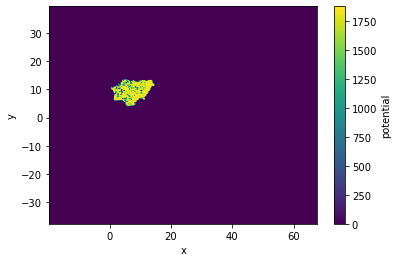

In [5]:
res_t["potential"].plot(vmin=0, vmax=res_t.potential[:].max())

Let's zoom-in. For that purpose we needs the boundaries, in this case of Nigeria. With `geopandas` we retrieve the geographic shapes (in vector format) for Nigeria and read the shape boundaries.

[ 2.69170169  4.24059418 14.57717777 13.86592398]


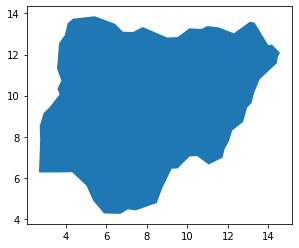

In [6]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
africa = world.query('continent == "Africa"')
countries = ["Nigeria"] # "Niger"]
shapes = world[world.name.isin(countries)].set_index('name')


import math

# For showing cutouts in Africa
# shapes = africa
shapes.plot();
print(shapes.total_bounds)
latmin, lonmin, latmax, lonmax = shapes.total_bounds

#latmin, lonmin, latmax, lonmax = math.floor(latmin), math.ceil(lonmin), math.floor(latmax), math.ceil(lonmax)

Now we need to add the boundaries to the plot. Note that we also adjusted the y-scale to better show the difference accross the regions.

In [7]:
res_t = res_t.sel(x=np.arange(latmin,latmax,0.01), y=np.arange(lonmin,lonmax,0.01), method="nearest")

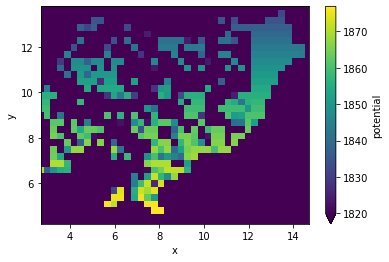

In [8]:
res_t["potential"].plot(vmin=1820, vmax=res_t.potential[:].max())
# ax.set_xlim(0,20)
# ax.set_ylim(0,10)

## Timeseries
Timeseris plots are helpful to analyse the seasonality and general variability. Below we show how you could plot some of these.

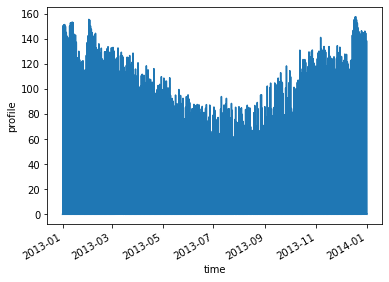

In [9]:
res_t['profile'].sum(dim='bus').plot()

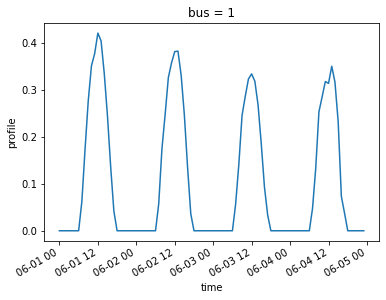

In [10]:
res_t['profile'].sel(bus="1", time=slice("2013-06-01", "2013-06-4")).plot()

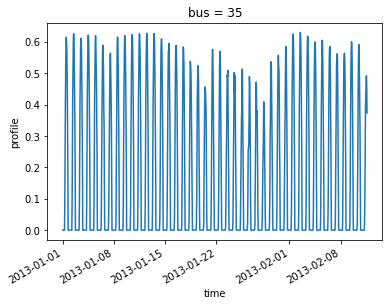

In [11]:
res_t["profile"].isel(bus=sum(range(10)), time=range(0,1000)).plot()

## Open hydro profile and plot

In [12]:
res_t_path_h = os.path.realpath("resources")+"/profile_hydro.nc"
res_h = xr.open_dataset(res_t_path_h)

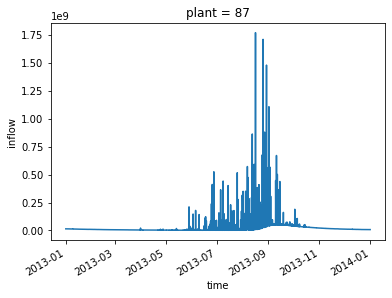

In [13]:
res_h["inflow"].isel(plant=90).plot()

In [14]:
# res_h.inflow.plot.line(x="time")